In [1]:
import torch
from src.distributions import MIMOFadingAWGNDistribution
from src.capacity_cost.discrete import BlahutArimotoContinuousOutput, BlahutArimotoDiscreteOutput
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(10)

# Discrete Output Case

For the accelerated BA please refer to the paper: 

Matz, Gerald, and Pierre Duhamel. "Information geometric formulation and interpretation of accelerated Blahut-Arimoto-type algorithms." Information theory workshop. IEEE, 2004.

In [2]:
# dist_channel = torch.tensor([[0.7, 0.1],
#                              [0.2, 0.2],
#                              [0.1, 0.7]])
# card_x = dist_channel.shape[1]

card_x, card_y = 64, 128
dist_channel = torch.rand(card_y, card_x) * 100
dist_channel = dist_channel / dist_channel.sum(0, keepdim=True)

init_p_x = torch.rand(card_x)
init_p_x = init_p_x / init_p_x.sum()

In [3]:
cba = BlahutArimotoDiscreteOutput(dist_channel, init_p_x=init_p_x, init_tau=1.0, accelerate=False, verbose=False) # where tau = 1 throughout
clogs = cba.run()

In [4]:
aba = BlahutArimotoDiscreteOutput(dist_channel, init_p_x=init_p_x, init_tau=1.0, accelerate=True, verbose=False)
alogs = aba.run()

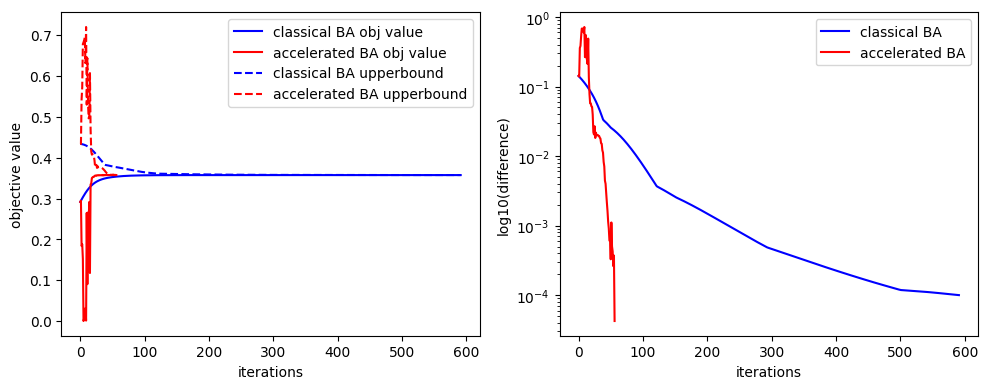

In [5]:
csteps = len(clogs['objval'])
cobjval = np.array(clogs['objval'])
cubval = np.array(clogs['ubval'])
cdiff = cubval - cobjval

asteps = len(alogs['objval'])
aobjval = np.array(alogs['objval'])
aubval = np.array(alogs['ubval'])
adiff = aubval - aobjval

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(range(csteps), cobjval, color='blue', label='classical BA obj value')
axes[0].plot(range(asteps), aobjval, color='red', label='accelerated BA obj value')
axes[0].plot(range(csteps), cubval, color='blue', label='classical BA upperbound', linestyle='--')
axes[0].plot(range(asteps), aubval, color='red', label='accelerated BA upperbound', linestyle='--')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('objective value')
axes[0].legend()

axes[1].plot(range(csteps), cdiff, color='blue', label='classical BA')
axes[1].plot(range(asteps), adiff, color='red', label='accelerated BA')
axes[1].set_xlabel('iterations')
axes[1].set_ylabel('log10(difference)')
axes[1].set_yscale('log')
axes[1].legend()

fig.tight_layout()
# fig.savefig('accelerated_BA.png')
fig.show()

# Continuous Output Case

We study the case of BPSK over an AWGN channel, i.e.,
$$
y = x + n
$$
where $x\in \{-\sqrt{P}, \sqrt{P}\}$ is the transmitted BPSK symbol, $n\sim \mathcal{N}(0, 1)$ is the noise.

In [6]:
dist_channel = MIMOFadingAWGNDistribution(torch.ones(1,1))
init_p_x = torch.rand(2)
init_p_x = init_p_x / init_p_x.sum()
capacity = []
power_list = np.arange(0.1, 30, 0.5)

for power in power_list:
    # print('power =', power)
    support_x = torch.tensor([[-1.], [1.]]) * np.sqrt(power)
    ba = BlahutArimotoContinuousOutput(dist_channel, support_x, init_p_x=init_p_x, init_tau=1.0, num_samples_y=256, accelerate=True, verbose=False)
    logs = ba.run()
    capacity.append(logs['rate'][-1]/ np.log(2))
    # init_p_x = torch.exp(logs['logp_x_optimal'])

Text(0, 0.5, 'capacity')

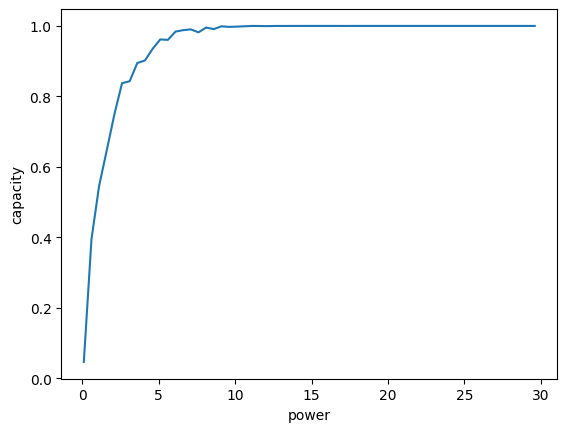

In [7]:
plt.plot(power_list, capacity)
plt.xlabel('power')
plt.ylabel('capacity')